In [1]:
# import modules
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Set seed
np.random.seed(123)

# Import data
turnout_data = pd.read_csv("/Users/kalika/Documents/Georgetown/Classes/Fall 2021/Data Science I/Python Homework/turnout.csv")

In [7]:
# Split 80% of data into train and 20% into test data
train = turnout_data.sample(frac=.8).reset_index(drop=True)
test = turnout_data.drop(train.index).reset_index(drop=True)

In [8]:
# Calculate class probabilities 
# Subset the data by class 
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class 
pr_vote1 = vote1.shape[0]/train.shape[0]
pr_vote0 = vote0.shape[0]/train.shape[0]

In [10]:
# Calculate conditional means/standard deviations of conditional distributions
# Collect the mean and standard dev. of two selected conditional distributions: education and income
dist_locs = \
{("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}
}

# Print
pp.pprint(dist_locs)

{('educate', 0): {'mean': 10.62836185819071, 'sd': 3.144794563899187},
 ('educate', 1): {'mean': 12.563811922753988, 'sd': 3.313411795406922},
 ('income', 0): {'mean': 2.7642088019559896, 'sd': 2.129945763720976},
 ('income', 1): {'mean': 4.251116288832915, 'sd': 2.9178548707903462}}


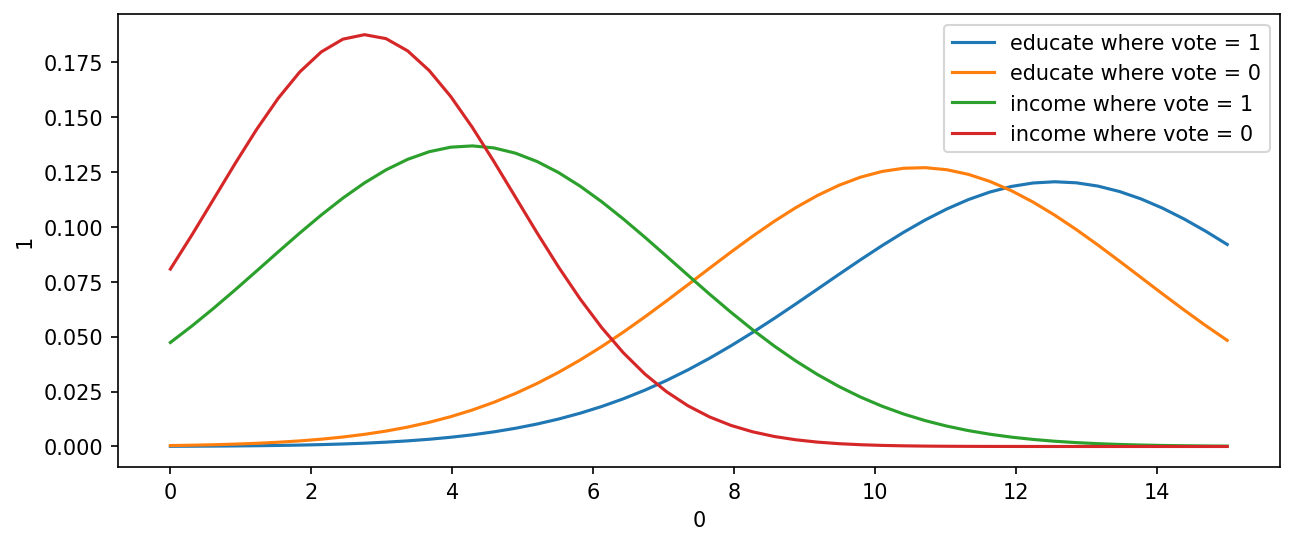

In [11]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(0,15)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")

In [13]:
# Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not based on that person's education and income
train_limited = train[["educate", "income"]] # limit train data to the two continuous variables we are using to predict vote patterns

def predict(data,dist_locs):
    ''' This function calculates the conditional probability of continuous variables, then returns the probabilities and most likely class.
    '''
    store_preds = []
    for i,row in data.iterrows():    
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_vote0
        pr_1 *= pr_vote1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train_limited,dist_locs)

# Predicted output
preds_train.head(10)

,pr_0,pr_1,pred
0,0.041287,0.067459,1
1,0.000921,0.030976,1
2,0.008068,0.069829,1
3,0.008068,0.069829,1
4,0.029095,0.099363,1
5,0.036427,0.058686,1
6,0.000013,0.005095,1
7,0.038486,0.062223,1
8,0.047771,0.091532,1
9,0.006948,0.066372,1


In [14]:
# Examine accuracy of training data 
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.744375

In [15]:
# Examine the predictive accuracy on the test data 
test_limited = test[["educate", "income"]]
preds_test = predict(test_limited,dist_locs)
accuracy_test = sum(test.vote == preds_test.pred)/test.shape[0]
accuracy_test

0.7

## Summarize results and findings
My findings show that of the people that voted in 2012, the mean education was 12.56 years of school, and mean income was 4.25. Of the people that did not vote in 2012, the mean education was 10.63 years of school, and mean income was 2.76.
I tried to use these two continuous variables to create a Naive Bayesian Classifier to see whether you can predict someone will vote based off education and income. My classifier was 74.4% accurate on the train data, and only 70% accurate on the test data. 